In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [64]:
filename_1d = "..\\..\\data\\moex\\SBER_200101_240530.csv"
filename_1h = "..\\..\\data\\moex\\SBER_240205_240603.csv"

dtype={
    '<TICKER>': 'string',
    '<PER>': 'string',
    '<DATE>': 'string',
    '<TIME>': 'string',
    '<OPEN>': 'float',
    '<HIGH>': 'float',
    '<LOW>': 'float',
    '<CLOSE>': 'float',
    '<VOLUME>': 'float',
}

df = pd.read_csv(filename_1d, delimiter=";", decimal=".", dtype=dtype)
df['timestamp'] = pd.to_datetime(df['<DATE>'] + ' ' + df['<TIME>'], format='%y%m%d %H%M%S')
df.drop(['<DATE>', '<TIME>', '<PER>', '<TICKER>'], axis=1, inplace=True)
df.set_index('timestamp', inplace=True)
df.rename(columns= {'<OPEN>' : 'open', '<HIGH>' : 'high', '<LOW>' : 'low', '<CLOSE>' : 'close', '<VOL>' : 'volume'}, inplace=True)

df = df.loc[:, ['close']]
df["rtn"] = df.close.pct_change()
df["log_rtn"] = np.log(df.close/df.close.shift(1))

df.head()


,close,rtn,log_rtn
timestamp,,,
2020-01-03,255.00,NaN,NaN
2020-01-06,253.90,-0.004314,-0.004323
2020-01-08,259.15,0.020677,0.020467
2020-01-09,257.99,-0.004476,-0.004486
2020-01-10,258.19,0.000775,0.000775


In [65]:
df_rolling = df[["rtn"]].rolling(window=21).agg(["mean", "std"])
df_rolling.columns = df_rolling.columns.droplevel()
df = df.join(df_rolling)
df


,close,rtn,log_rtn,mean,std
timestamp,,,,,
2020-01-03,255.00,NaN,NaN,NaN,NaN
2020-01-06,253.90,-0.004314,-0.004323,NaN,NaN
2020-01-08,259.15,0.020677,0.020467,NaN,NaN
2020-01-09,257.99,-0.004476,-0.004486,NaN,NaN
2020-01-10,258.19,0.000775,0.000775,NaN,NaN
...,...,...,...,...,...
2024-05-27,317.09,-0.012181,-0.012255,0.001341,0.006184
2024-05-28,318.22,0.003564,0.003557,0.001419,0.006202
2024-05-29,320.38,0.006788,0.006765,0.001746,0.006299


In [66]:
N_SIGMAS = 3
df["upper"] = df["mean"] + N_SIGMAS * df["std"]
df["lower"] = df["mean"] - N_SIGMAS * df["std"]
df["outlier"] = ((df["rtn"] > df["upper"]) | (df["rtn"] < df["lower"]))

outlier = df.loc[df["outlier"] == True, :]
outlier

,close,rtn,log_rtn,mean,std,upper,lower,outlier
timestamp,,,,,,,,
2020-03-13,198.60,0.128986,0.121320,-0.010792,0.044918,0.123961,-0.145545,True
2020-10-02,208.80,-0.081107,-0.084586,-0.001885,0.021864,0.063708,-0.067479,True
2021-05-11,307.16,-0.040695,-0.041546,0.004331,0.014099,0.046628,-0.037966,True
2022-02-21,201.00,-0.196899,-0.219275,-0.008049,0.057524,0.164523,-0.180620,True
2022-02-24,132.18,-0.366134,-0.455918,-0.022311,0.097674,0.270711,-0.315333,True
2022-09-20,125.10,-0.093741,-0.098430,0.000050,0.029051,0.087203,-0.087104,True
2023-01-11,149.96,0.050067,0.048854,0.003557,0.014726,0.047736,-0.040621,True
2023-03-17,193.59,0.103391,0.098388,0.008871,0.026106,0.087190,-0.069447,True
2023-07-31,267.40,0.072818,0.070289,0.005381,0.017610,0.058211,-0.047448,True


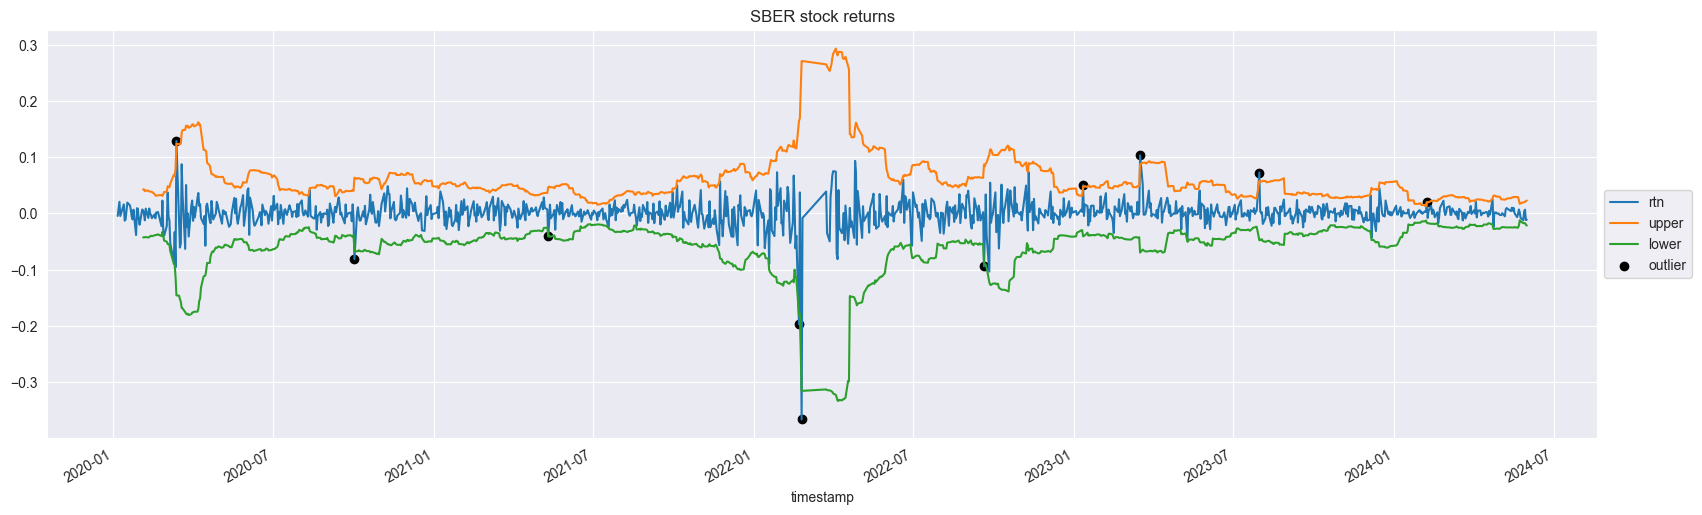

In [67]:
fig, ax = plt.subplots()
df[["rtn", "upper", "lower"]].plot(ax=ax, figsize=(20, 6))
ax.scatter(df.loc[df["outlier"]].index, df.loc[df["outlier"], "rtn"], color="black", label="outlier")
ax.set_title("SBER stock returns")
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.show()


In [68]:
def identify_outliers(dt, column, window_size, n_sigmas):
    """Function for identifying outliers using rolling statistics"""
    dt = dt[[column]].copy()
    dt_rolling = dt.rolling(window=window_size).agg(["mean", "std"])
    dt_rolling.columns = dt_rolling.columns.droplevel()
    dt = dt.join(df_rolling)
    dt["upper"] = dt["mean"] + n_sigmas * dt["std"]
    dt["lower"] = dt["mean"] - n_sigmas * dt["std"]
    return (dt[column] > dt["upper"]) | (dt[column] < dt["lower"])
